# Food classification with custom dataset


## Setup


### Importing PyTorch and setting up device-agnostic code


In [1]:
# Importing packages

# Type hinting
from typing import List, Tuple, Dict, Any

# Other
import random
import numpy as np

# Utils
from tqdm.notebook import tqdm
from torchinfo import summary
from timeit import default_timer as timer

# File handling
import os
import zipfile
import requests
from pathlib import Path

# Image visualization
from PIL import Image
import matplotlib.pyplot as plt

# Handling data
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

# Modelling
import torch
from torch import nn

In [2]:
# Setting up device-agnostic code
device = 'mps' if torch.mps.is_available() else 'cpu'

### Functions


In [3]:
def walk_through_dir(dir_path: Path) -> None:
    '''Walks through dir_path returning its contents'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.'
        )

In [4]:
def plot_transformed_images(
    image_paths: List[Path],
    transform: transforms.Compose,
    n_images: int = 3,
    seed: int | None = None,
) -> None:
    '''
    Selects random images from a path of images and loads/transforms them.
    Then plots the original vs the transformed version
    '''

    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n_images)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)

            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nSize: {transformed_image.shape}')
            ax[1].axis(False)

            fig.suptitle(f'Class {image_path.parent.stem}', fontsize=16)

In [5]:
def find_classes(directory: Path | str) -> Tuple[List[str], Dict[str, int]]:
    '''
    Finds the class folder names in a target directory.
    '''

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(
            f'Couldn\'t find any classes in {directory}... Please check the file structure'
        )

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [6]:
def display_random_images(
    dataset: datasets.ImageFolder,
    classes: List[str],
    n: int = 10,
    display_shape: bool = True,
    seed: int | None = None,
) -> None:
    '''Displays a random image from the dataset.'''
    if n > 10:
        n = 10
        display_shape = False
        print(
            f'For display purposes, n shouldn\'t be larger than 10, setting it to t10 and removing shape display'
        )

    if seed:
        random.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, target_sample in enumerate(random_sample_idx):
        target_image, target_label = (
            dataset[target_sample][0],
            dataset[target_sample][1],
        )

        target_image_adjust = target_image.permute(1, 2, 0)

        plt.subplot(1, n, i + 1)
        plt.imshow(target_image_adjust)
        plt.axis('off')
        if classes:
            title = f'Class: {classes[target_label]}'

            if display_shape:
                title = title + f'\nshape: {target_image_adjust.shape}'

            plt.title(title)

In [7]:
def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
) -> Tuple[float, float]:
    '''Step of the training of a model'''

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [8]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: str,
) -> Tuple[float, float]:
    '''Step of the testing of a model'''

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [9]:
def train(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device: str = 'cpu',
) -> Dict[str, List[float]]:
    '''Trains a given model tracking loss and accuracy through training and testing.'''

    results = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
        )

        print(
            f'''
======================================      
Epoch:                       |   {epoch + 1}   |  
======================================      
Train Loss:                  | {train_loss:.3f} |

Train Accuracy:              | {train_acc:.3f} |            
--------------------------------------
Test Loss:                   | {test_loss:.3f} |

Test Accuracy:               | {test_acc:.3f} |
              '''
        )

        results['train_loss'].append(
            train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss
        )
        results['train_acc'].append(
            train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc
        )
        results['test_loss'].append(
            test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss
        )
        results['test_acc'].append(
            test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc
        )

    return results

In [10]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

## 1. Preparing data


In [11]:
# Setting up paths
base_dir = Path('../data/pizza_steak_sushi')

train_dir = base_dir / 'train'
test_dir = base_dir / 'test'

In [12]:
# Creating transforms
simple_transform = transforms.Compose(
    [transforms.Resize(size=(64, 64)), transforms.ToTensor()]
)

In [13]:
# Loading data
simple_train_data = datasets.ImageFolder(train_dir, transform=simple_transform)
simple_test_data = datasets.ImageFolder(test_dir, transform=simple_transform)

In [14]:
# Setting batch size
BATCH_SIZE = 32

# Setting up num_workers
cpu_count = os.cpu_count()
NUM_WORKERS = 0 if cpu_count is None else cpu_count

In [15]:
# Setting up Dataloaders
simple_train_dataloader = DataLoader(
    simple_train_data, batch_size=BATCH_SIZE, shuffle=True
)

simple_test_dataloader = DataLoader(simple_test_data, batch_size=BATCH_SIZE)

In [16]:
# Getting sample datapoint
sample_data = next(iter(simple_test_dataloader))

In [17]:
# Getting classes
class_to_idx = simple_train_data.class_to_idx
class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

## 2. Creating model


In [18]:
# Creating model class
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()

        # Convolutional blocks
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 13 * 13, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(
            self.conv_block_2(self.conv_block_1(x))
        )  # operator fusion

In [19]:
# Creating instance of model
torch.manual_seed(42)

test_model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_to_idx)).to(
    device
)

In [20]:
# Visualizing model information with torchinfo summary
summary(test_model, input_size=sample_data[0].shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [21]:
(sample_data[0].shape)

torch.Size([32, 3, 64, 64])

## 3. Train and evaluate model


In [22]:
# Setting random seeds
torch.manual_seed(42)
torch.mps.manual_seed(42)

# Setting number of epochs
NUM_EPOCHS = 50

# Instantiating model
base_model = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_to_idx),
).to(device)

# Setting up loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=base_model.parameters(), lr=0.001)

In [ ]:
# Setting timer
start_time = timer()

# Training base model
base_model_results = train(
    model=base_model,
    train_dataloader=simple_train_dataloader,
    test_dataloader=simple_test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device,
)

# Ending timer
end_time = timer()
print(
    f'''
======================================
Total training time: {end_time - start_time:.3f} seconds |
======================================
    '''
)

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch:                       |   1   |  
Train Loss:                  | 1.106 |

Train Accuracy:              | 0.305 |            
--------------------------------------
Test Loss:                   | 1.098 |

Test Accuracy:               | 0.301 |
              

Epoch:                       |   2   |  
Train Loss:                  | 1.100 |

Train Accuracy:              | 0.328 |            
--------------------------------------
Test Loss:                   | 1.070 |

Test Accuracy:               | 0.542 |
              

Epoch:                       |   3   |  
Train Loss:                  | 1.087 |

Train Accuracy:              | 0.488 |            
--------------------------------------
Test Loss:                   | 1.081 |

Test Accuracy:               | 0.492 |
              

Epoch:                       |   4   |  
Train Loss:                  | 1.084 |

Train Accuracy:              | 0.402 |            
--------------------------------------
Test Loss:                   |

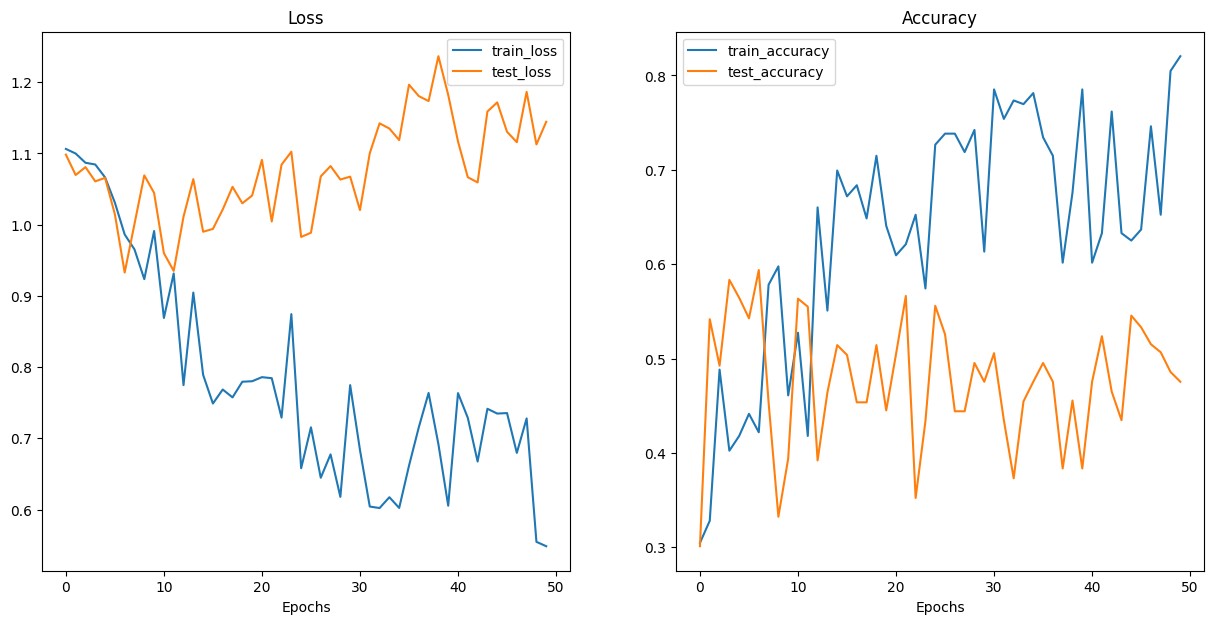

In [ ]:
# Plotting results curves
plot_loss_curves(base_model_results)

## 4. Training and evaluating model with data augmentation

As seen in the previous model, the loss on the training data was decreasing and its accuracy increasing, this however was not reflected on the test data. This is a high indication of overfitting, meaning the model hasn't actually learned patterns within the data, but instead has memorized the training data. This can be highlighted by the disparity between the growth of the accuracy curve in the training data, whilst the curve of the testing data has been about the same.

To try and mitigate this effect, we'll "introduce" new data into each set in order to increase the sheer number of opportunities for the model to learn. Since we don't need for the testing data to be different, we can simply use `simple_test_dataloader`, only needing to create a new dataloader for the training data.


### Setting up data


In [ ]:
# Creating new transforms
data_augmentation_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
    ]
)

In [ ]:
# Setting batch size
BATCH_SIZE = 32

In [ ]:
# Loading data with DA (Data augmentation)
da_train_data = datasets.ImageFolder(train_dir, transform=data_augmentation_transform)
da_test_data = datasets.ImageFolder(test_dir, transform=simple_transform)

# Setting up DA Dataloader
da_train_dataloader = DataLoader(da_train_data, batch_size=BATCH_SIZE, shuffle=True)
da_test_dataloader = DataLoader(da_test_data, batch_size=BATCH_SIZE)

### Creating new model


In [ ]:
# Model for training with data augmentation
da_model = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_to_idx),
).to(device)

In [ ]:
# Creating new optimizer
optimizer = torch.optim.Adam(
    da_model.parameters(),
    lr=0.001,
)

# Creating new loss function
loss_fn = nn.CrossEntropyLoss()

# Setting number of epochs
NUM_EPOCHS = 50

In [ ]:
# Setting timer
start_time = timer()

# Training DA model
da_model_results = train(
    model=da_model,
    train_dataloader=da_train_dataloader,
    test_dataloader=da_test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device,
)

# Ending timer
end_time = timer()
print(
    f'''
======================================
Total training time: {end_time - start_time:.3f} seconds |
======================================
    '''
)

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (32x28090 and 1690x3)

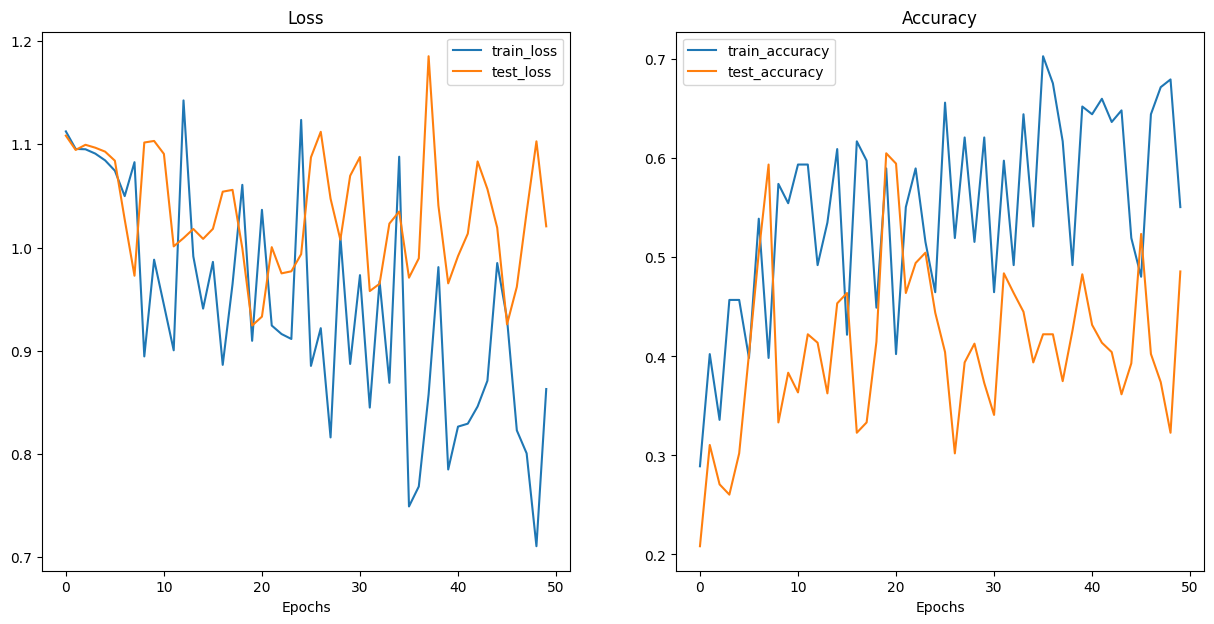

In [ ]:
# Plotting new loss and acc curves
plot_loss_curves(da_model_results)